In [1]:
!pip install -q -U ultralytics
!pip install -U -q ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 16.3 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd 
import random
import torch
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import glob
import shutil
import yaml
from concurrent.futures import ThreadPoolExecutor

import os
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

import cv2
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

In [3]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6095.9/8062.4 GB disk)


Seed

In [4]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Создание датасета

In [5]:
DIR_PATH = '/kaggle/input/logodet3k/LogoDet-3K'

logo_dataset = pd.DataFrame(glob.glob(f"{DIR_PATH}/*/*/*"), columns=["file_path"])
logo_dataset["extension"] = logo_dataset["file_path"].apply(lambda x: x.split(".")[-1])
logo_dataset["logo_category"] = logo_dataset["file_path"].apply(lambda x: x.split(os.sep)[-3])
logo_dataset["logo_name"] = logo_dataset["file_path"].apply(lambda x: x.split(os.sep)[-2])
logo_dataset.head()

,file_path,extension,logo_category,logo_name
0,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
1,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
2,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
3,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
4,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery


Фильтрация данных (сокращение набора)

In [6]:
def filter_dataset(logo_dataset:pd.DataFrame = logo_dataset, 
                  q:float = 0.05):
    '''
    Функция для фильтрации (сокращения) исходного датасета.
    В этом есть смысл ввиду предположения избыточности полного набора данных 
    при решении задачи Object Detection c одним классом (logo)

    Параметры:
    -logo_dataset: исходный датасет с логотипами (pd.DataFrame, default: logo_dataset)
    -q: квантиль для подрезки распределения (убрать небольшое число логотипов) (float, default: 0.05)
    '''

    logo_dataset = logo_dataset[logo_dataset['logo_category'] != 'Medical']
    assert logo_dataset['extension'].value_counts()['jpg'] == logo_dataset['extension'].value_counts()['xml']
    logo_dataset = logo_dataset[logo_dataset['logo_category'] != 'Sports']
    assert logo_dataset['extension'].value_counts()['jpg'] == logo_dataset['extension'].value_counts()['xml']
    value_counts = logo_dataset['logo_name'].value_counts()
    threshold = np.quantile(value_counts.values, q = q)
    logo_names_to_remove = value_counts[value_counts < threshold].index
    logo_dataset = logo_dataset[~logo_dataset['logo_name'].isin(logo_names_to_remove)]
    assert logo_dataset['extension'].value_counts()['jpg'] == logo_dataset['extension'].value_counts()['xml']

    return logo_dataset
    
logo_dataset_copy = logo_dataset.copy()
logo_dataset_copy = filter_dataset(logo_dataset = logo_dataset_copy, 
                                  q = 0.25)
print(f"Dataset shape: {logo_dataset_copy.shape}")
print(f"No. of .jpg files {logo_dataset_copy['extension'].value_counts()['jpg']}")
print(f"No. of .xml files {logo_dataset_copy['extension'].value_counts()['xml']}")
logo_dataset_copy.head()
    

Dataset shape: (281440, 4)
No. of .jpg files 140720
No. of .xml files 140720


,file_path,extension,logo_category,logo_name
0,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
1,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
2,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
3,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
4,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery


Чуть-чуть сократили датасет. Для демонстрационного варианта решения задачи должно хватить. Если будет долго обучаться, то можно сократить ещё

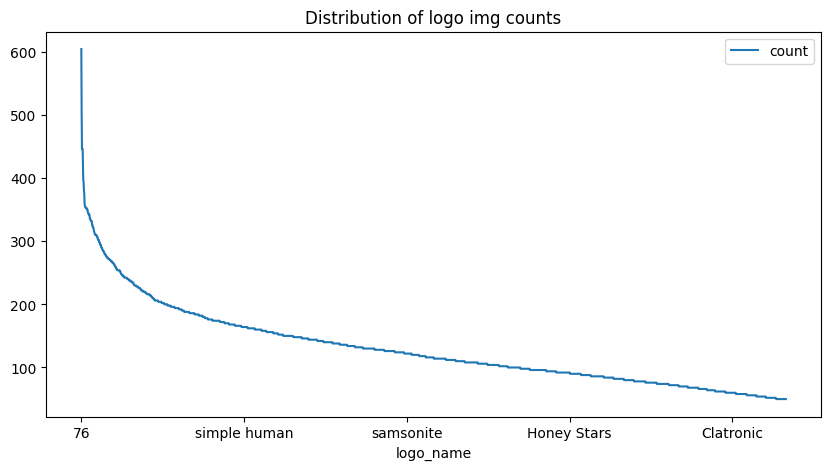

In [7]:
logo_dataset_copy["logo_name"].value_counts().reset_index().plot(
    x="logo_name", y="count", figsize=(10,5), title="Distribution of logo img counts")

plt.show()

Далее стоит собрать файл для обучения YOLO (fine-tuning)

In [8]:
dataset_dst_dir = "/kaggle/working/logodet3k"
if os.path.exists(dataset_dst_dir):
    shutil.rmtree(dataset_dst_dir)
os.makedirs(f"{dataset_dst_dir}/train", exist_ok=True)
os.makedirs(f"{dataset_dst_dir}/val", exist_ok=True)

Вспомогательные словари формата ```{'logo_name': label} и {label: 'logo_name'}``` 

In [9]:
classname2idx = {logo_name: idx for idx, logo_name in enumerate(sorted(logo_dataset_copy["logo_name"].unique()))}
idx2classname = {idx: logo_name for logo_name, idx in classname2idx.items()}

# Мы же решаем задачу детекции лого
classname2idx = {"logo": 0}
idx2classname = {0: 'logo'}
print(classname2idx)

{'logo': 0}


In [10]:
class_name_idx_map_str = "\n".join([f"    {idx}: {class_name}" for class_name, idx in classname2idx.items()])
print(class_name_idx_map_str)

    0: logo


Вид файловой структуры (dataset_config)

In [11]:
dataset_config = f"""
path: {dataset_dst_dir} 
train:
    - train
val:
    - val

# test:
#     - test

# Classes
names:
{class_name_idx_map_str}
"""
print(dataset_config)


path: /kaggle/working/logodet3k 
train:
    - train
val:
    - val

# test:
#     - test

# Classes
names:
    0: logo



In [12]:
with open("dataset_config.yaml", "w") as f:
    f.write(dataset_config)
with open("dataset_config.yaml", "r") as f:
    datcon = yaml.safe_load(f)
    print(datcon)

{'path': '/kaggle/working/logodet3k', 'train': ['train'], 'val': ['val'], 'names': {0: 'logo'}}


Далее необходимо привести данные к входному формату YOLO. Для этого используем готовую функцию

In [13]:
example_xml_file = '/kaggle/input/logodet3k/LogoDet-3K/Clothes/2xist/1.xml'

def convert_to_YOLO_format(xml_path:str = example_xml_file, output_dir = None,
                          name2class_dict:dict = classname2idx):
    '''
    Функция по заданному файлу (.xml) создает файл c аннотациями для YOLO

    Параметры:
    -xml_path: путь к файлу формата .xml (str, default: example_xml_file)
    -output_dir: путь для записи YOLO аннотаций (default: None)
    -name2class_dict: словарь для получения классов-меток (dict, default: classname2idx)
    '''
    
    yolo_lines = []
    tree = ET.parse(xml_path)
    root = tree.getroot()
    image_width = float(root.find("size/width").text)
    image_height = float(root.find("size/height").text)
    depth = float(root.find("size/depth").text)

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        class_index = classname2idx.get(class_name, 0)
        yolo_line = f"{class_index} {x_center} {y_center} {width} {height}"
        yolo_lines.append(yolo_line)
        
    if output_dir is not None:
        with open(output_dir, "w") as f:
            f.write("\n".join(yolo_lines))
            
    return yolo_lines

example = convert_to_YOLO_format(name2class_dict = {})
print(example)


['0 0.7592975206611571 0.42689295039164493 0.378099173553719 0.10704960835509138']


Будет получаться формат:  ```label x_center y_center width height```

train-test-split

In [14]:
logo_dataset_copy['is_train'] = True
train_logo_dataset, test_logo_dataset = train_test_split(logo_dataset_copy, test_size=0.25, random_state=SEED)
test_logo_dataset['is_train'] = False
final_logo_dataset = pd.concat([train_logo_dataset, test_logo_dataset])
final_logo_dataset.reset_index(drop=True, inplace=True)
print(f"Logo dataset shape: {final_logo_dataset.shape}")
final_logo_dataset.head()

Logo dataset shape: (281440, 5)


,file_path,extension,logo_category,logo_name,is_train
0,/kaggle/input/logodet3k/LogoDet-3K/Electronic/...,xml,Electronic,zopo,True
1,/kaggle/input/logodet3k/LogoDet-3K/Food/oh hen...,jpg,Food,oh henry,True
2,/kaggle/input/logodet3k/LogoDet-3K/Food/milk-b...,jpg,Food,milk-bone,True
3,/kaggle/input/logodet3k/LogoDet-3K/Clothes/sor...,jpg,Clothes,sorel,True
4,/kaggle/input/logodet3k/LogoDet-3K/Others/APCO...,xml,Others,APCO,True


In [15]:
def copy_to_working_dir(sample, 
                    classnam2idx:dict = classname2idx):

    '''
    Функция для создания каталога обучения YOLO

    Параметры:
    -sample: строка данных из датафрейма (logo_dataset)
    -classname2idx: словарь меток (dict, default: classname2idx)
    '''
    train_folder = "train" if sample["is_train"] else "val"
    input_file = sample["file_path"]
    output_file = os.path.join(dataset_dst_dir, train_folder, "__".join(sample["file_path"].split(os.sep)[-3:]))
    
    # print(train_folder)
    # print(input_xml_file)
    # print(output_xml_file)
    
    if not os.path.exists(output_file):
        shutil.copy(input_file, output_file)
    if not os.path.exists(output_file.replace(".jpg", ".txt")):
        convert_to_YOLO_format(input_file.replace(".jpg", ".xml"), 
                            output_file.replace(".jpg", ".txt"), classname2idx)
    return True

first_row = final_logo_dataset.iloc[1][:]
# print(first_row)
copy_to_working_dir(first_row)


True

Далее необходимо запустить каталога

In [16]:
def create_yolo_data(logo_dataset:pd.DataFrame = final_logo_dataset):
    '''
    Функция создаст каталог для обучения модели YOLO

    Параметры:
    -logo_dataset: исходный датасет (pd.DataFrame, default: final_logo_dataset)
    '''

    copy_to_working_dir_results = []

    with ThreadPoolExecutor() as e:
        for _, row in tqdm(logo_dataset.iterrows()):
            status = e.submit(copy_to_working_dir, dict(row))
            copy_to_working_dir_results.append(status)

    copy_to_working_results = logo_dataset_copy.apply(lambda x: copy_to_working_dir(x), axis=1)
    print(copy_to_working_results.sum(), logo_dataset_copy.shape[0])

create_yolo_data()

0it [00:00, ?it/s]

281440 281440


Далее необходимо настроить отображение bounding box (-ов)

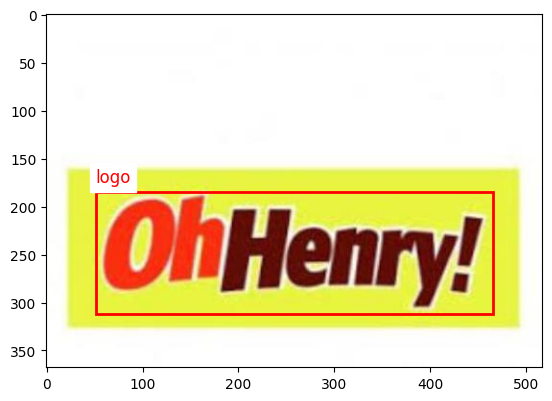

In [17]:
example_image_path = '/kaggle/working/logodet3k/train/Food__oh henry__68.jpg'

def plot_image_with_bboxes(image_path:str = example_image_path):
    '''
    Функция для построения изображения и bounding box'ов

    Параметры:
    -image_path: путь к изображению (str, default: example_image_path)
    '''

    annotations_path = image_path.replace('.jpg', '.txt')
    
    image = Image.open(image_path)
    width, height = image.size
    
    with open(annotations_path, 'r') as file:
        lines = file.readlines()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for line in lines:
        class_index, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split())
        
        x_center *= width
        y_center *= height
        bbox_width *= width
        bbox_height *= height

        xmin = x_center - bbox_width / 2
        ymin = y_center - bbox_height / 2

        rect = patches.Rectangle((xmin, ymin), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin - 10, f'{idx2classname[class_index]}', color='red', fontsize=12, backgroundcolor='white')
        
    # plt.axis('off')
    plt.show()
    
plot_image_with_bboxes()
    

Наконец, можем заняться настройкой YOLO и запуском обучения!

In [18]:
yolo_logo_detection = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 134MB/s]


Пример инференса


image 1/1 /kaggle/input/template-img/messi.jpg: 448x640 8 persons, 1 sports ball, 44.0ms
Speed: 14.8ms preprocess, 44.0ms inference, 289.6ms postprocess per image at shape (1, 3, 448, 640)


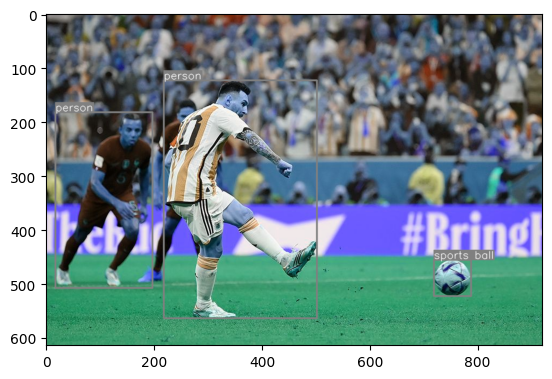

In [19]:
example_image = '/kaggle/input/template-img/messi.jpg'

def plot_bboxes(result):
    '''
    Функция для отображения предсказаний по результату инференса YOLO

    Параметры:
    -result: предсказание модели YOLO
    '''
    
    annotator = Annotator(result.orig_img)
    boxes = result.boxes
    for box in boxes:
        b = box.xyxy[0]
        c = box.cls
        conf = box.conf
        if conf > 0.75:
            annotator.box_label(b, yolo_logo_detection.names[int(c)])
    img = annotator.result() 
    return img

plt.imshow(plot_bboxes(yolo_logo_detection(example_image)[0]))
plt.show()

Пробуем запустить обучение

In [20]:
yolo_logo_detection.train(data='dataset_config.yaml', epochs=1)

Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=dataset_config.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/logodet3k/train... 140720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140720/140720 [02:06<00:00, 1110.82it/s]

train: WARNING ⚠️ /kaggle/working/logodet3k/train/Food__violet crumble__5.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/logodet3k/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/logodet3k/val... 35357 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35357/35357 [00:31<00:00, 1115.91it/s]

val: WARNING ⚠️ /kaggle/working/logodet3k/val/Food__violet crumble__5.jpg: 1 duplicate labels removed


val: New cache created: /kaggle/working/logodet3k/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      8.72G      1.382      1.482       1.53         40        640: 100%|██████████| 8795/8795 [1:37:31<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1105/1105 [06:58<00:00,  2.64it/s]


                   all      35357      43297      0.613      0.641      0.649      0.389

1 epochs completed in 1.745 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1105/1105 [06:48<00:00,  2.71it/s]


                   all      35357      43297      0.613      0.641      0.649      0.388
Speed: 0.1ms preprocess, 8.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa1597dadd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Примере инференса модели после fine-tuning

In [5]:
yolo_logo_detection = YOLO('/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/yolo/yolo_weigths/best.pt')

In [3]:
def plot_bboxes(result, conf_threshold = 0.3):
    '''
    Функция для отображения предсказаний по результату инференса YOLO

    Параметры:
    -result: предсказание модели YOLO
    '''
    
    annotator = Annotator(result.orig_img)
    boxes = result.boxes
    for box in boxes:
        b = box.xyxy[0]
        c = box.cls
        conf = box.conf
        print(conf)
        if conf > conf_threshold:
            annotator.box_label(b, yolo_logo_detection.names[int(c)])
    img = annotator.result() 
    return img


image 1/1 /Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/adidas_shop.jpg: 384x640 4 logos, 113.7ms
Speed: 1.7ms preprocess, 113.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
tensor([0.4517])
tensor([0.3932])
tensor([0.3039])
tensor([0.2506])


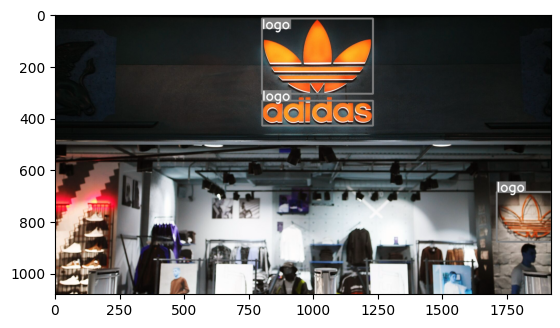

In [12]:
example_inference_image = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/adidas_shop.jpg'
plt.imshow(plot_bboxes(yolo_logo_detection(example_inference_image)[0]))
plt.show()


image 1/1 /Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/nike.jpg: 320x640 2 logos, 105.1ms
Speed: 1.5ms preprocess, 105.1ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)
tensor([0.6180])
tensor([0.4135])


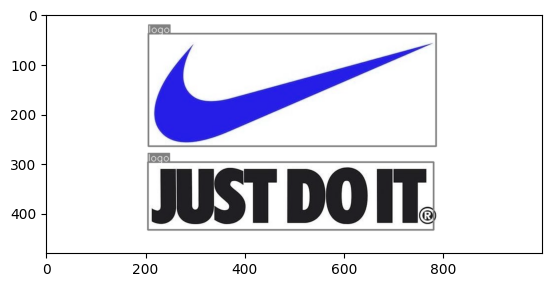

In [13]:
example_inference_image = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/nike.jpg'
plt.imshow(plot_bboxes(yolo_logo_detection(example_inference_image)[0]))
plt.show()


image 1/1 /Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/vk.jpg: 640x640 3 logos, 190.3ms
Speed: 1.3ms preprocess, 190.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
tensor([0.5197])
tensor([0.3732])
tensor([0.2906])


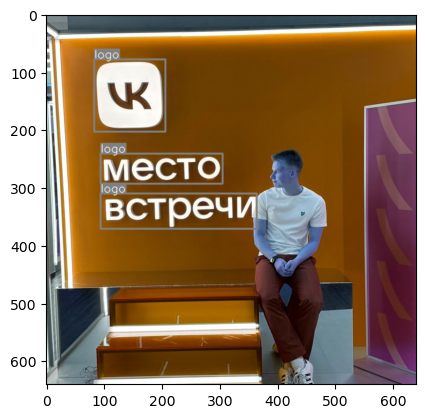

In [7]:
example_inference_image = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/vk.jpg'
plt.imshow(plot_bboxes(yolo_logo_detection(example_inference_image)[0], conf_threshold = 0.25))
plt.show()


image 1/1 /Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/gant.png: 640x512 3 logos, 155.1ms
Speed: 3.9ms preprocess, 155.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 512)
tensor([0.3351])
tensor([0.2949])
tensor([0.2834])


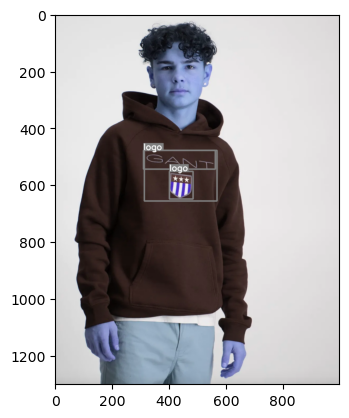

In [9]:
example_inference_image = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/gant.png'
plt.imshow(plot_bboxes(yolo_logo_detection(example_inference_image)[0], conf_threshold = 0.25))
plt.show()

Детекция работает и может быть использована, как часть общего Pipeline